 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8886/notebooks/keras/Mikes_inout.ipynb#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="http://localhost:8886/notebooks/keras/Mikes_inout.ipynb#Quick-test-network" data-toc-modified-id="Quick-test-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quick test network</a></span></li><li><span><a href="http://localhost:8886/notebooks/keras/Mikes_inout.ipynb#Load-model-predictions" data-toc-modified-id="Load-model-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load model predictions</a></span></li><li><span><a href="http://localhost:8886/notebooks/keras/Mikes_inout.ipynb#Scoreboard" data-toc-modified-id="Scoreboard-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scoreboard</a></span></li></ul></div>

## Setup

In [201]:
# Imports 
from importlib import reload
import utils; reload(utils); from utils import *
import data_generator; reload(data_generator); from data_generator import *
import models; reload(models); from models import *

In [104]:
# Limit Tensorflow GPU memory usage. 
# Note that it's not possible to change the allocation or release memory again.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [133]:
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)

In [3]:
# Plotting setup
%matplotlib inline
np.random.seed(42)
sns.set_style('dark')
sns.set_palette('deep')
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (10,7)

In [4]:
# Define data paths
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/Mikes_inout/' # Full dataset
%ls $data_dir

SPCAM_mean_detailed.nc              SPCAM_outputs_valid_by_lon_flat.nc
SPCAM_outputs_detailed.nc           SPCAM_std_detailed.nc
SPCAM_outputs_train_by_lon_flat.nc


In [14]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
    'QRL': 2,
    'QRS': 2,
    'PRECT': 1,
    'FLUT': 1,
})

## Quick test network

In [205]:
# Load the dataset
train_set_lon = DataSet(data_dir, 'SPCAM_outputs_train_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys())
valid_set_lon = DataSet(data_dir, 'SPCAM_outputs_valid_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys())

In [106]:
train_set_lon.targets.shape, train_set_lon.features.shape

((3681792, 86), (3681792, 86))

In [206]:
model = fc_model(train_set_lon.features.shape[1], train_set_lon.targets.shape[1], [512, 512], 
                 0.0001, 'mae')

In [211]:
model.fit(train_set_lon.features, train_set_lon.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_lon.features, valid_set_lon.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 46s - loss: 0.0145 - rmse: 0.0308 - log_loss: -1.6248 - total_error: 98.7898 - unexplained_error: 73.2796 - rsquared: 0.2572 - total_error_avgAx0: 82.9743 - rsquared_avgAx0: 0.1141 - val_loss: 0.0144 - val_rmse: 0.0305 - val_log_loss: -1.6317 - val_total_error: 97.7712 - val_unexplained_error: 72.0479 - val_rsquared: 0.3198 - val_total_error_avgAx0: 77.5787 - val_rsquared_avgAx0: 0.0617


In [212]:
preds = model.predict(valid_set_lon.features, batch_size=512)

In [213]:
plt.plot(valid_set_lon.renorm_outputs(valid_set_lon.targets[0]), label='t')
plt.plot(valid_set_lon.renorm_outputs(preds[0]), label='p')
plt.legend(); plt.show

AssertionError: Only for normalized targets

<function matplotlib.pyplot.show>

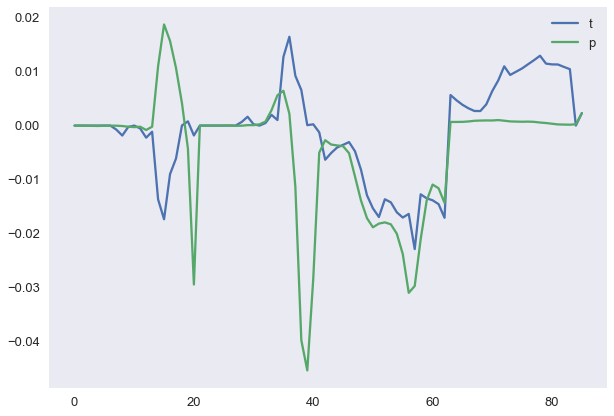

In [214]:
plt.plot(valid_set_lon.targets[0], label='t')
plt.plot(preds[0], label='p')
plt.legend(); plt.show

## Load model predictions

In [134]:
model1 = keras.models.load_model('./models/fc_1024_1024_512_512_by_lon_inout_Mike.h5')

In [145]:
preds1 = model1.predict(valid_set_lon.features, batch_size=1024)

## Scoreboard

In [112]:
valid_set_lon.targets.shape, valid_set_lon.target_names

((938496, 86), odict_keys(['SPDT', 'SPDQ', 'QRL', 'QRS', 'PRECT', 'FLUT']))

In [154]:
i=20000

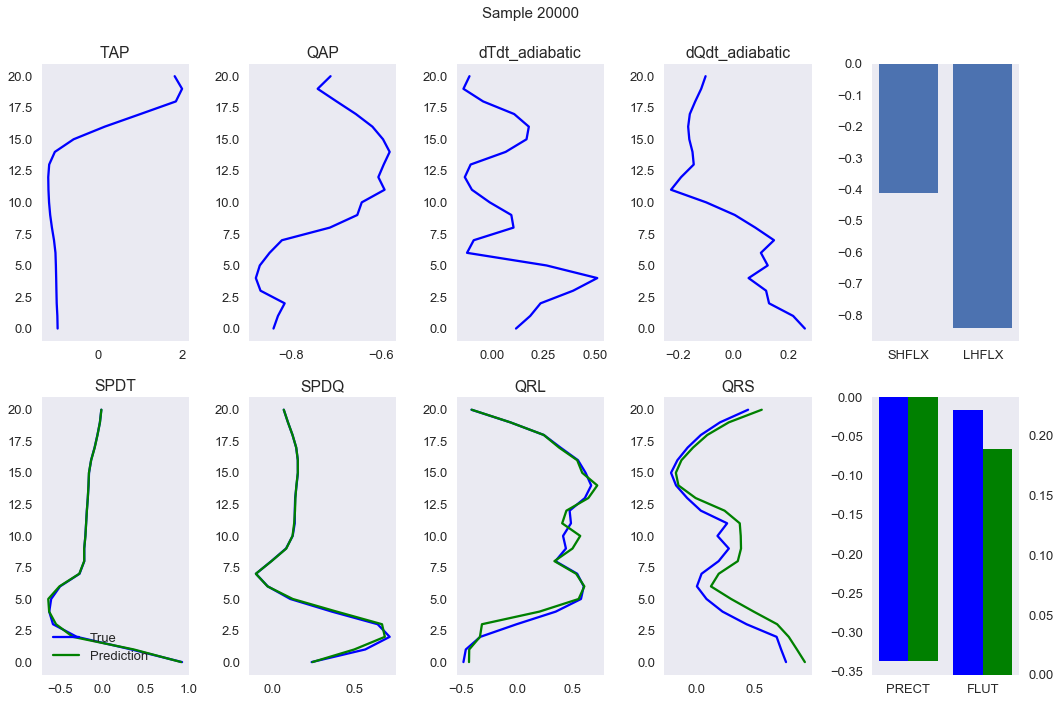

In [155]:
vis_features_targets_from_pred2(valid_set_lon.features, 
                                   valid_set_lon.targets, preds1,
                                   i, list(valid_set_lon.feature_names), 
                                   list(valid_set_lon.target_names))

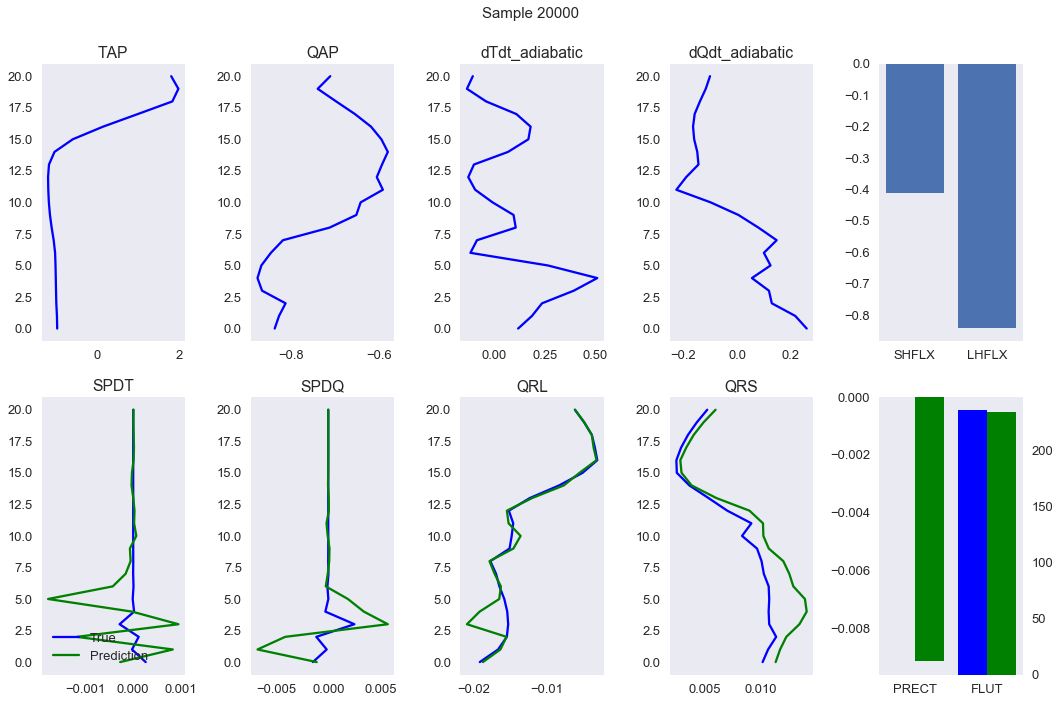

In [156]:
import utils; reload(utils); from utils import *
vis_features_targets_from_pred2(valid_set_lon.features, 
                                   valid_set_lon.renorm_outputs(valid_set_lon.targets), 
                                valid_set_lon.renorm_outputs(preds1),
                                   i, list(valid_set_lon.feature_names), 
                                   list(valid_set_lon.target_names))

In [125]:
valid_set_lon.target_mean[-3:], valid_set_lon.target_std[-3:]

(array([  4.66571329e-03,   2.72590081e+00,   2.25952347e+02]),
 array([  7.13120587e-03,   8.11179962e+00,   4.26481476e+01]))

In [165]:
prec = valid_set_lon.renorm_outputs(valid_set_lon.targets)[:, -2]

In [197]:
prec.mean() * 1e-3, prec.std()

(0.0027041831338821304, 8.0172085257932046)

In [198]:
olr = valid_set_lon.renorm_outputs(valid_set_lon.targets)[:, -1]

In [199]:
olr.mean(), olr.std()

(225.30940997336862, 42.013150992006572)

In [200]:
olr.mean() * 1e-5

0.0022530940997336863